In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import CompressedFisher

# A set of routines that define the toy model

We consider nKs points, at positions $k$, from a poisson distribution with rate, $\mu(\mathbf{k})$, given by
\begin{align}
\mu(\mathbf{k}) = \alpha+\beta k + \gamma \sqrt{k}
\end{align}

In [3]:
# Define number and location of points
nKs = 100
ks = 10**np.linspace(-4,0,nKs)


def muk_theory(ks,params):
    """
    Evalute the toy model for the rate of the Poisson process at a set of positiosn
    
    Args:
        ks ([array of floats]): ks at which to evaluate the model
        params ([array of floats]): The values of the parameters to 
    Returns:
        [array of shape [nks]]: The poisson rate at the requested values 
    """

    alpha,beta,gamma= params
    return alpha+beta*ks+gamma*ks**.5



def generateSims(params,nSims=1):
    """
    Generate draw realizations from the toy model with the given set of parameters
    
    Args:
        params ([list floats]): The values of the parameters values to draw realizations at.
        nSims (ind): The number of sims to generate (default: `1`)
    Returns:
        [array [nSims,nKs] ]: The poisson simulation realizations
    """


    pk_mu = muk_theory(ks,params)
    return np.array([np.random.poisson(pk,nSims) for pk in pk_mu]).T



def generate_deriv_sims(parameter_names,params,deltaParams,nSims):
    """
    Generates simulations for use as finite difference derivatives.
    These are central finite differences, ths for each parameter 
    simulations are generated at $\theta\pm \delta\theta$.
    
    Args:
        parameter_names ([list of names]): the names of the parameters
        params ([array]): the values of the parameters about which to compute the derivatives
        deltaParams ([array]): The parameter step size
        nSims ([int]): The number of simulations
    
    Returns:
        [dictionary]: The simulations for computing the derivates.  Each entry in the dicitonary 
                      is an array of size [2,nParams,nKs]. 
                    
    """
    deriv_sims = {}
    
    for i,name in enumerate(parameter_names):
        derivs_ens = np.zeros([2,nSims,nKs])
        params_plus = np.array(params)
        params_plus[i]+=deltaParams[i]
        
        params_minus = np.array(params)
        params_minus[i]-=deltaParams[i]
        
        derivs_ens[0] = generateSims(params_minus,nSims)  
        derivs_ens[1] = generateSims(params_plus,nSims)
        deriv_sims[name] = derivs_ens
    return deriv_sims




"""
For this toy model we can compute the true Fisher information analytically.
""" 


def theoretical_derivs(params):
    """
    Computes the derivatives analytical
    
    Args:
        params ([array]): The values where the derivatives are to be evaluated
    
    Returns:
         an array of shape [3,nKs] : The derivatives for the 3 parameters
    """
    pk_mu = muk_theory(ks,params)
    nParams = len(params)
    derivs_thry = np.zeros([nParams,nKs])
    derivs_thry[0] = np.ones(nKs)
    derivs_thry[1] = ks.copy()
    derivs_thry[2] = np.sqrt(ks)
    return derivs_thry

def fisherInformationTheory(params):
    """
    Compute the exact Fisher informations
    
    Args:
        params ([array]): The values where the Fisher information are to be evaluated
    
    Returns:
        [matrix nParams x nParams]: The analytical Fisher information (i.e. the `truth')
    """
    derivs = theoretical_derivs(params)
    nParams = len(params)
    mu = muk_theory(ks,params)
    fisher = np.zeros([nParams,nParams])
    for i in range(nParams):
        for j in range(i+1):
            tmp = np.sum(derivs[i]*derivs[j]/mu)
            fisher[i,j] = fisher[j,i] = tmp
    return fisher

# Set the fiducial parameter values and parameter step sizes

In [4]:
params_fid = np.array([1,1,1.])
delta_params = np.array([.05,.05,.05,])
parameter_names = [r"$\alpha$", r"$\beta$", r"$\gamma$"]
dict_param_steps = {parameter_names[i]:delta_params[i] for i in range(len(params_fid))}

# Specify the number of simulations to use to estimate the mean and covariance

In [5]:
nSimsCovMat = 20000
nSims_deriv = 400000

# Evaluate the true fisher information

In [6]:

fisher_true = fisherInformationTheory(params_fid)
print(fisher_true)

[[81.56791613  5.47697572 12.95510815]
 [ 5.47697572  2.41918403  3.35935472]
 [12.95510815  3.35935472  5.47697572]]


# Specifcy the fraction of simulations to be used to compute the compression (the remainder are used to evaluate the compressed Fisher information)

In [7]:
compress_frac_split = 0.5

# Generate our mock data
## Simulations for estimating the variances and simulates simulations for estimating finite difference derivatives

In [8]:

covmat_sims = generateSims(params_fid,nSimsCovMat)
dict_deriv_sims = generate_deriv_sims(parameter_names,params_fid,delta_params,nSims=nSims_deriv)

Note the structure of the derivaties is a dictionary with elements [ $(\theta-\delta\theta,\theta+\delta\theta)$, $N_\mathrm{sims}$, $N_{ks}$]

# Initialize a CompressedFisher poisson obejct
### Specifiy the names of the parameters, the number of derivatives and the order of the finite difference spline


In [9]:
cFisher = CompressedFisher.poissonFisher(parameter_names,nSims_deriv,deriv_finite_dif_accuracy=2)


### Pass the simulations to the compressed fisher object
### For the poisson case simulations are needed to estimate the variance and means 
### the derivatives are needed along with step sizes. Note this function also accepts a function instead of a dictionary of derivates. See the docs. for more info

In [10]:

cFisher.initailize_variance(covmat_sims)
cFisher.initailize_deriv_sims(dic_deriv_sims=dict_deriv_sims,dict_param_steps=dict_param_steps)


## Split the simulations into part for compression and part for estimating the compressed fisher information

In [11]:
cFisher.generate_deriv_sim_splits(compress_frac_split)




In [13]:
cFisher.compute_deriv_rate_covar(parameter_names).shape

(3, 3, 100)

## Compute the fisher forecast constraints and the estimated bias

### standard fisher

In [14]:


stnd_constraint    = cFisher.compute_fisher_forecast(parameter_names)
stnd_constraint_bias = cFisher.est_fisher_forecast_bias(parameter_names)


In [15]:
np.diag(stnd_constraint)**.5

array([0.15110113, 1.61468514, 1.25248918])

In [16]:
print(f'Parameter \t True Fisher \t standard Fisher \t Est. Fractional bias ')
for i,name in enumerate(parameter_names):
    print(f'{name} \t {np.linalg.inv(fisher_true)[i,i]**.5:.3f}  \t\t  {stnd_constraint[i,i]**.5:.3f} \t\t     {(stnd_constraint_bias/stnd_constraint)[i,i]:.3f} ')
    

Parameter 	 True Fisher 	 standard Fisher 	 Est. Fractional bias 
$\alpha$ 	 0.172  		  0.151 		     0.102 
$\beta$ 	 2.046  		  1.615 		     0.391 
$\gamma$ 	 1.584  		  1.252 		     0.374 


The estimated fractional bias can be used to assess if the forecast is converged (and so valid).
Note that it is the ratio of the bias to the variance (not the constraint that is important).
This should be $\lesssim .2$.

### Compressed Fisher


In [17]:

compressed_constraint = cFisher.compute_compressed_fisher_forecast(parameter_names)
compressed_constraint_bias = cFisher.est_compressed_fisher_forecast_bias(parameter_names)


In [18]:
print(f'Parameter \t True Fisher \t Compressed Fisher \t Est. Fractional bias ')
for i,name in enumerate(parameter_names):
    print(f'{name} \t {np.linalg.inv(fisher_true)[i,i]**.5:.3f}  \t\t  {compressed_constraint[i,i]**.5:.3f} \t\t     {(compressed_constraint_bias/compressed_constraint)[i,i]:.3f} ')
    

Parameter 	 True Fisher 	 Compressed Fisher 	 Est. Fractional bias 
$\alpha$ 	 0.172  		  0.190 		     0.016 
$\beta$ 	 2.046  		  2.418 		     0.029 
$\gamma$ 	 1.584  		  1.898 		     0.028 


As above the est. bias can be used to assess when the compressed forecast is reliable. 
When the compressed forecast is valid, so too is the combined estimator below

### Combined Fisher

In [19]:

combined_constraint = cFisher.compute_combined_fisher_forecast(parameter_names)
        

In [20]:
print(f'Parameter \t True Fisher \t Compressed Fisher  ')
for i,name in enumerate(parameter_names):
    print(f'{name} \t {np.linalg.inv(fisher_true)[i,i]**.5:.3f}  \t\t  {combined_constraint[i,i]**.5:.3f} ')
    

Parameter 	 True Fisher 	 Compressed Fisher  
$\alpha$ 	 0.172  		  0.167 
$\beta$ 	 2.046  		  1.969 
$\gamma$ 	 1.584  		  1.539 


# Additional convergence tools

### Examine how the estimates change with the number of simulations used in the forecast

In [21]:

std_nsim, std_mns,std_stds = cFisher.run_fisher_deriv_stablity_test(parameter_names,)

comp_nsim, comp_mns,comp_stds = cFisher.run_compressed_fisher_deriv_stablity_test(parameter_names,compress_frac_split)
geom_nsim, geom_mns,geom_stds = cFisher.run_combined_fisher_deriv_stablity_test(parameter_names,compress_frac_split)


40000.0 
 [0.14066287 1.02787153 0.81099745] 
 [0.01958876 0.23641332 0.14146927]
80000.0 
 [0.14630577 1.24994248 1.00911893] 
 [0.03373557 0.31551787 0.27904986]
133333.3333333333 
 [0.15439511 1.45741419 1.16244397] 
 [0.02844976 0.34087982 0.2605659 ]
160000.0 
 [0.15513475 1.48833616 1.17544379] 
 [0.03875457 0.38348056 0.10574666]
200000.0 
 [0.15695131 1.5358169  1.22008381] 
 [0.03492503 0.2098834  0.13153408]
400000.0 
 [0.16266293 1.71905989 1.3567515 ] 
 [0. 0. 0.]
40000.0 
 [0.35120838 8.44647434 5.86282874] 
 [0.35113779 5.02967293 4.28063968]
80000.0 
 [0.28423629 4.43523372 3.58147711] 
 [0.15434102 2.37268139 1.96058576]
133333.3333333333 
 [0.22772518 2.79407022 2.24445918] 
 [0.05829539 1.56515322 1.15919111]
160000.0 
 [0.23134972 3.26753641 2.56384802] 
 [0.06170666 0.60166818 0.90617969]
200000.0 
 [0.19655409 2.60975416 2.03837453] 
 [0.02407668 0.6989699  0.57788941]
400000.0 
 [0.1828964  2.33690678 1.82165851] 
 [0. 0. 0.]
40000.0 
 [0.1788516  2.40167048 1.835

## Convergence of the Standard Fisher forecast

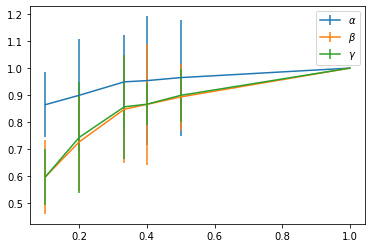

In [22]:

for i,p in enumerate(parameter_names):
    plt.errorbar(std_nsim/std_nsim[-1],std_mns[:,i,i]**.5/std_mns[-1,i,i]**.5,yerr=std_stds[:,i,i]**.5/std_mns[-1,i,i]**.5,label=parameter_names[i])
#plt.plot(geom_nsim/geom_nsim[-1],(geom_nsim/geom_nsim[-1])**.5,scaley=False,color='k',alpha=.5,linestyle=':')

plt.legend()
plt.show()


Some of the parameter forecasts change by \gtsim 20% when doubling the number of simulations. This implies the forecast is not fully converged

## Convergence of the compressed fisher forecast

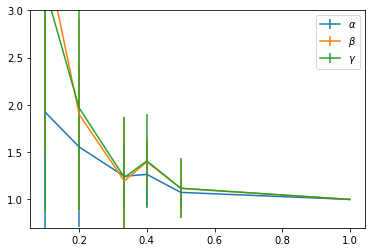

In [23]:

for i,p in enumerate(parameter_names):
    plt.errorbar(comp_nsim/comp_nsim[-1],comp_mns[:,i,i]**.5/comp_mns[-1,i,i]**.5,yerr=comp_stds[:,i,i]**.5/comp_mns[-1,i,i]**.5,label=parameter_names[i])
#plt.plot(geom_nsim/geom_nsim[-1],(geom_nsim/geom_nsim[-1])**.5,scaley=False,color='k',alpha=.5,linestyle=':')

plt.legend()
plt.ylim([.7,3])
plt.show()

The errors here also change, but they decrease with the number of simulations. This is the regime where the compressed forecast is valid. 

## Convergence of the combined fisher forecast 

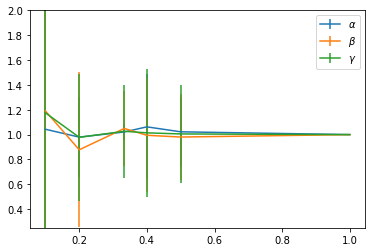

In [24]:


for i,p in enumerate(parameter_names):
    plt.errorbar(geom_nsim/geom_nsim[-1],geom_mns[:,i,i]**.5/geom_mns[-1,i,i]**.5,yerr=geom_stds[:,i,i]**.5/geom_mns[-1,i,i]**.5,label=parameter_names[i])
#plt.plot(geom_nsim/geom_nsim[-1],(geom_nsim/geom_nsim[-1])**.5,scaley=False,color='k',alpha=.5,linestyle=':')
plt.legend()
plt.ylim([.25,2])
plt.show()
#plt.yscale('log')
#plt.yscale('log')

The combined estimator is fairly stable to variations in the number simulations used. This provides further support that the combined forecast is converged

# Tools to obtain the Fisher information and estimated biases on these quantities

In [25]:

stnd_fisher     = cFisher._compute_fisher_matrix(parameter_names)
stnd_fisher_err     = cFisher._compute_fisher_matrix_error(parameter_names)


compressed_fisher  = cFisher._compute_compressed_fisher_matrix(parameter_names)
compressed_fisher_err  = cFisher._compute_compressed_fisher_matrix_error(parameter_names)


combined_fisher = cFisher._compute_combined_fisher_matrix(parameter_names)